In [1]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
import logging
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Input,LSTM,Conv1D,Dropout, Dense, BatchNormalization, Activation, Bidirectional
from tensorflow.keras import Model


def allow_soft_placement():
    physical_devices = tf.config.experimental.list_physical_devices('GPU')
    if  len(physical_devices) == 0:
        logging.warning("Not enough GPU hardware devices available")
    else:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)

allow_soft_placement()

import os
os.chdir('../src/models/')

import sys
from dotenv import load_dotenv, find_dotenv
import numpy as np
import pandas as pd

sys.path.append(os.path.abspath("../.."))
# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
# load up the entries as environment variables
load_dotenv(dotenv_path)
# import pandas as pd

from src.code_snippets.dataprep.embeddings_preprocessing.data_preparation import (
    sentences_to_indices,
    pretrained_embedding_layer
)

from src.code_snippets.utils.abstract_classes import Trainer
from src.code_snippets.dataprep.embeddings_preprocessing.glove.reader import read_glove_file,get_word_index_dicts
from src.code_snippets.dataprep.embeddings_preprocessing.data_preparation import pretrained_embedding_layer
import random
from src.code_snippets.utils.data_handler import read_pickle
import matplotlib.pyplot as plt
from src.code_snippets.utils.data_handler import read_pickle,save_to_pickle



In [3]:
import seaborn as sns
import tensorflow.keras.backend as K

def plot_metrics(history,metric='f1',higher_is_better = True,linestyle = '-',ylim = (0,1)):
    try:
        history = history.history
    except:
        pass
    metrics = [ i for i in history.keys() if metric in i]
    losses = [ i for i in history.keys() if 'loss' in i]        
    for m in metrics:
        h = np.array(history[m])
        if higher_is_better:
            h = 1 - h
        ax = plt.plot(h ,label = m, color = 'green' if 'val' in m else 'blue',linestyle=linestyle)
    plt.legend()
    ymin,ymax = ylim
    plt.ylim(ymin,ymax)

def extract_trial_results(x):
    experiment = space_eval(space,{k:(v[0] if v else 0) for k,v in x['misc']['vals'].items()})
    experiment['num_epochs'] = np.argmax(x['result']['model_history']['val_f1_metric'])

    experiment['f1_train'] = x['result']['model_history']['f1_metric'][experiment['num_epochs']]
    experiment['f1_val'] = x['result']['model_history']['val_f1_metric'][experiment['num_epochs']]
    return experiment

class ManyToOneSeqModel(Trainer):

    def __init__(self,train_data,val_data,embedding_dir):
        self.train_data = train_data
        self.val_data = val_data
        self.embedding_dir = embedding_dir
        self.gensim_model = read_glove_file(self.embedding_dir)
        self.word_to_index,self.index_to_words = get_word_index_dicts(self.gensim_model)
        
        self.m_X, self.n_X = self.train_data['X_indices'].shape
        self.m_X_aux, self.n_X_aux = self.train_data['X_aux'].shape
    
    def set_model(self):
        pretrained_embedding_layer(self.gensim_model, self.word_to_index)
    
    def save_model(self):
        pass
    def fit_model(self):
        pass
    def generate_metrics(self):
        pass


def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [4]:
seed = 100
random.seed(seed)
np.random.seed(seed)

In [5]:
train_data = read_pickle('../../data/processed/processed_data_train.pickle')
val_data = read_pickle('../../data/processed/processed_data_val.pickle')

In [6]:
num_observations = len(train_data['X_aux'])
idx = np.arange(num_observations)

sample_portion = 0.1
sample_size = int(num_observations*sample_portion)
print(sample_size)

12292


In [7]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
assert num_gpus_available == 1, 'GPU IS NOT AVAILABLE' 
print("Num GPUs Available: ",num_gpus_available )

Num GPUs Available:  1


In [8]:
np.random.seed(seed)
sampled_idx = np.random.choice(idx,sample_size,replace = False)

use_sample = False

if use_sample:
    train_data['X_indices'] = train_data['X_indices'][sampled_idx]
    train_data['X_aux'] = train_data['X_aux'][sampled_idx]
    train_data['y'] = train_data['y'][sampled_idx]
else:
    train_data['X_indices'] = train_data['X_indices']
    train_data['X_aux'] = train_data['X_aux']
    train_data['y'] = train_data['y']

In [9]:
trainer = ManyToOneSeqModel(train_data,
                            val_data,
                            "../../data/raw/pretrained_embeddings/glove.twitter.27B/glove.twitter.27B.200d.txt")


In [10]:
def many_to_one_LSTM(n_units = 2**7,
                     add_recurrent_layer= False,
                     dropout = 0.1,
                     spatial_dropout = 0,
                     hidden_dense_units = 0,
                     learning_rate = 0.01,
                     bidirectional = True,
                     seed = 100):

    #Input layer
    sentence_indices = Input((trainer.n_X),dtype='int32')

    # Embedding Layer
    embedding_layer = pretrained_embedding_layer(trainer.gensim_model,
                                                 trainer.word_to_index)

    # Propagate sentence_indices through your embedding layer
    embeddings = embedding_layer(sentence_indices)   
    embeddings = SpatialDropout1D(spatial_dropout,seed= seed)(embeddings)
    #LSTM 1
    if bidirectional:
        X = Bidirectional(LSTM(n_units,return_sequences=True if add_recurrent_layer else False))(embeddings)
    else:
        X = LSTM(n_units,return_sequences=True if add_recurrent_layer else False)(embeddings)

    if add_recurrent_layer:
        #LSTM 2
        if bidirectional:
            X = Bidirectional(LSTM(n_units,return_sequences=False))(X)
        else:
            X = LSTM(n_units,return_sequences=False)(X)
    
    if hidden_dense_units>0:
        #Hiden Dense Layer 1
        X = Dense(hidden_dense_units)(X)
        X = BatchNormalization()(X) 
        X = Activation(activation='relu')(X)
        X = Dropout(dropout,seed = seed)(X)
    
    #Output layer
    X = Dense(1,activation='sigmoid')(X)

    model = Model(sentence_indices,X)
    
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    #TODO: Remove AUC from metrics
    model.compile(loss='binary_crossentropy',metrics = [f1_metric,tf.keras.metrics.AUC()],optimizer=opt)


    return model

In [12]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt.pyll.stochastic import sample
from functools import partial
from glob import glob
import re

def hyperopt_model(params: dict, verbose: int = 0):
    #Set output dir
    export_directory = '../../models/'
    model_name = 'many_to_one_LSTM'
    full_export_directory = os.path.join(export_directory,model_name)
    
    tf.keras.backend.clear_session()
    print(params)
    
    model = many_to_one_LSTM(
                             n_units=params['n_units'],
                             add_recurrent_layer = params['add_recurrent_layer'],
                             dropout=params['dropout'],
                             spatial_dropout = params['spatial_dropout'],
                             hidden_dense_units=params['hidden_dense_units'],
                             learning_rate = params['learning_rate'],
                             bidirectional = params['bidirectional']
                            )


    
                        
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_metric',
                                                     min_delta=1e-4,
                                                     patience = 15,
                                                     mode = 'max',
                                                     restore_best_weights = True,
                                                     verbose = 1)
    
    
    multi_step_history = model.fit(trainer.train_data['X_indices'],
                                   trainer.train_data['y'],
                                   epochs=params['epochs'],
                                   batch_size=params['batch_size'],
                                   shuffle=True,
                                   validation_data = [trainer.val_data['X_indices'],trainer.val_data['y']],
                                   verbose = verbose,
                                   callbacks=[early_stopping])
    loss = 1 - early_stopping.best
    
    #Keep log of best loss and save the corresponding model
    metric_file_name = os.path.join(full_export_directory,'metric.txt')
    try:
        with open(metric_file_name) as f:
            min_loss = float(f.read().strip())  # read best metric,
    except FileNotFoundError:
            min_loss = 1000  # else just use current value as the best

    if loss < min_loss:
        print(f"Found new best model with loss {loss}... Saving model.")
        model.save(os.path.join(full_export_directory,"model.h5"))  # save best to disc and overwrite metric
        with open(metric_file_name, "w") as f:
            f.write(str(loss))
    sys.stdout.flush() 
    return {'loss': loss, 'status': STATUS_OK, 'model_history':multi_step_history.history}

class safeHyperopt:
    
    def __init__(self,
                 model,
                 space,
                 version,
                 total_trials = 50,
                 init_max_trials = 11,
                 export_directory = '../../models/',
                 model_name = 'many_to_one_LSTM'
                ):
        
        self.model = model
        self.space = space
        self.init_max_trials = init_max_trials
        self.total_trials = total_trials
        self.export_directory = export_directory
        self.model_name = model_name
        self.version = str(version)
        self.full_export_directory = os.path.join(self.export_directory,
                                                  self.model_name,
                                                  f'V{self.version}')
        
        
        if not os.path.exists(self.full_export_directory):
            os.mkdir(self.full_export_directory)
            
        save_to_pickle(self.space,os.path.join(self.full_export_directory,\
                                           'space_hyperopt.pickle'))

    def get_latest_trial_version(self,path):
        latest_version = 0
        versions = list(map(lambda x: int(re.findall('\d',x)[0]),glob(path)))
        if versions:
            latest_version = max(versions)
        return latest_version

    def run_trials(self, verbose: bool = True):

        trials_step = 1  # how many additional trials to do after loading saved trials. 1 = save after iteration
        n_startup_jobs = 10
        
        try:  # try to load an already saved trials object, and increase the max
            trials = read_pickle(os.path.join(self.full_export_directory,\
                                                           'trials.pickle'))
            print("Found saved Trials! Loading...")            
            self.init_max_trials = len(trials.trials) + trials_step
            
            best_loss = trials.best_trial['result']['loss']

            print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), self.init_max_trials, trials_step))
        except:  # create a new trials object and start searching
            trials = Trials()

        algo = partial(tpe.suggest, n_startup_jobs=n_startup_jobs)
        best = fmin(self.model,self.space, algo=algo, max_evals=self.init_max_trials, trials=trials,verbose=verbose)

        print("Best:", best)

        # save the trials object
        self.current_num_trials = len(trials.trials)
        save_to_pickle(trials,os.path.join(self.full_export_directory,\
                                                           'trials.pickle'))

    def run_train_loop(self):
        
        
        try:  # try to load an already saved trials object, and increase the max
            trials = read_pickle(os.path.join(self.full_export_directory,\
                                                           'trials.pickle'))
            self.current_num_trials = len(trials.trials)
        except:
            self.current_num_trials=0
            
        while True:
            
            print('NUM TRIALS',self.current_num_trials)
            if self.current_num_trials<self.total_trials:
                self.run_trials()
            else:
                print("Total trials reaches!")
                break
    


In [13]:

space = {   'n_units': 256,
            'add_recurrent_layer': True,
            'dropout': hp.choice('dropout', np.arange(.4,0.6,0.1)),
            'spatial_dropout':hp.choice('spatial_dropout',np.arange(.4,.6,.1)),
            'hidden_dense_units': 128,
            'batch_size' :2**8,
            'epochs' : 100,
            'learning_rate':10**hp.uniform('learning_rate',-3,-2.559),
            'bidirectional':True
        }



In [14]:
2**8

256

In [15]:

shp = safeHyperopt(model = hyperopt_model,
                   space = space,
                   version = 3,
                   total_trials = 30)



In [16]:
shp.run_train_loop()

NUM TRIALS 0
{'add_recurrent_layer': True, 'batch_size': 256, 'bidirectional': True, 'dropout': 0.5, 'epochs': 100, 'hidden_dense_units': 128, 'learning_rate': 0.0011840153494092692, 'n_units': 256, 'spatial_dropout': 0.4}
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op Sub in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op Mul in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op Add in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op VarIsInitializedOp in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op LogicalNot in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op Assert in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op AssignVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RandomUniform in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op __inference_distributed_function_25501 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_distributed_function_33711 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op Identity in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ReadVariableOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op DeleteIterator in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localh

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op __inference_distributed_function_106533 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0    

Executing op ModelDataset in de

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in dev

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDat

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op __inference_distributed_function_357775 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op __inference_distributed_function_365985 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op __inference_distributed_function_436810 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op __inference_distributed_function_445020 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op __inference_distributed_function_522016 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op __inference_distributed_function_530226 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op __inference_distributed_function_607180 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op __inference_distributed_function_615390 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op __inference_distributed_function_696472 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op __inference_distributed_function_704682 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0        

Executing op __inference_distributed_function_783637 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0       

Executing op __inference_distributed_function_791847 in device /job:localhost/replica:0/ta

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0       

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0       

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0       

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0       

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0       

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0       

Executing op __inference_distributed_function_862672 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op __inference_distributed_function_870882 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0      

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op __inference_distributed_function_939622 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_distributed_function_947832 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:loca

Executing op __inference_distributed_function_1031083 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_distributed_function_1039293 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:l

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op __inference_distributed_function_1130544 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op __inference_distributed_function_1221795 in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/de

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op Mod

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Restoring model weights from the end of the best epoch.         
Epoch 00021: early stopping                                     
100%|██████████| 17/17 [32:58<00:00, 1978.56s/tria

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Restoring model weights from the end of the best epoch.         
Epoch 00027: early stopping                                     
100%|██████████| 18/18 [42:21<00:00, 2541.98s/trial, best loss: 0.14509689807891846]
Best: {'dropout': 1, 'learning_rate': -2.8612851114364943, 'spatial_dropout': 1}
NUM TRIALS 18
Found saved Trials! Loading...
Rerunning from 18 trials to 19 (+1) trials
{'add_recurrent_layer': True, 'batch_size'

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Restoring model weights from the end of the best epoch.         
Epoch 00024: early stopping                                     
100%|██████████| 19/19 [37:40<00:00, 2260.19s/trial, best loss: 0.14509689807891846]
Best: {'dropout': 1, 'learning_rate': -2.8612851114364943, 'spatial_dropout': 1}
NUM TRIALS 19
Found saved Trials! Loading...
Rerunning from 19 trials to 20 (+1) trials
{'add_recurrent_layer': True, 'batch_size': 256, 'bidirectional': True, 'dropout': 0.4, 'epochs': 100, 'hidden_dense_units': 128, 'learning_rate': 0.0022067634932462234, 'n_units': 256, 'spatial_dropout': 0.5}
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:C

{'add_recurrent_layer': True, 'batch_size': 256, 'bidirectional': True, 'dropout': 0.4, 'epochs': 100, 'hidden_dense_units': 128, 'learning_rate': 0.0017490710723429934, 'n_units': 256, 'spatial_dropout': 0.5}
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RangeDataset in device /job:l

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

E

Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0

Executing op VarHan


W0517 10:38:41.227543 139921511192384 callbacks.py:1286] Early stopping conditioned on metric `val_f1_metric` which is not available. Available metrics are: loss,f1_metric,auc



KeyboardInterrupt: 

In [37]:
trials = read_pickle('../../models/many_to_one_LSTM/V2/trials.pickle')
space = read_pickle('../../models/many_to_one_LSTM/V2/space_hyperopt.pickle')

In [38]:
best_params = space_eval(space,trials.argmin) 
print(trials.best_trial['result']['loss'])
best_params


0.1438361406326294


{'add_recurrent_layer': True,
 'batch_size': 128,
 'bidirectional': True,
 'dropout': 0.4,
 'epochs': 100,
 'hidden_dense_units': 128,
 'learning_rate': 0.0017436142055397088,
 'n_units': 256,
 'spatial_dropout': 0.4}

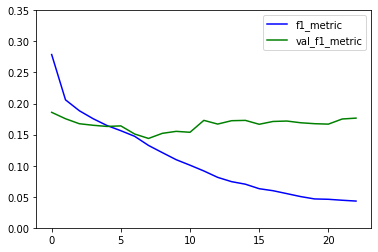

In [39]:
plot_metrics(trials.best_trial['result']['model_history'],ylim=(0,0.35))

In [40]:
results = list(map(extract_trial_results,trials.trials))

In [41]:
results = pd.DataFrame(results)
results.drop('epochs',axis=1,inplace=True)
results.sort_values(by='f1_val',inplace=True,ascending=False)

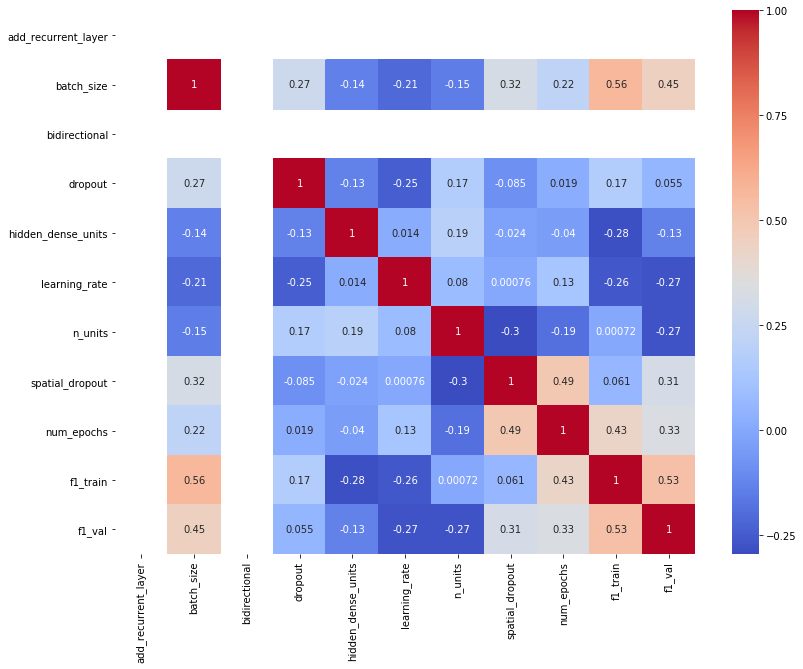

In [23]:
plt.figure(figsize=(13,10))
sns.heatmap(results.corr(),cmap='coolwarm',annot=True)
plt.show()

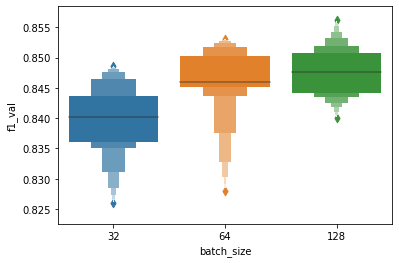

In [70]:
sns.boxenplot(x='batch_size',y='f1_val',data=results)


In [69]:
results

,add_recurrent_layer,batch_size,bidirectional,dropout,hidden_dense_units,learning_rate,n_units,spatial_dropout,num_epochs,f1_train,f1_val
42,True,128,True,0.4,128,0.001744,256,0.4,7,0.867419,0.856164
17,True,128,True,0.5,32,0.001325,128,0.5,7,0.827694,0.853941
22,True,128,True,0.1,128,0.001200,128,0.5,10,0.854757,0.853082
1,True,64,True,0.1,64,0.002505,128,0.5,6,0.825115,0.853020
39,True,128,True,0.1,0,0.001232,128,0.5,7,0.851730,0.852486
44,True,64,True,0.4,16,0.003445,256,0.4,16,0.824835,0.852097
36,True,128,True,0.1,32,0.001420,256,0.5,10,0.865408,0.851216
40,True,128,True,0.0,128,0.002971,64,0.5,24,0.865865,0.851115
6,True,128,True,0.5,32,0.001236,128,0.5,21,0.885610,0.850787
4,True,128,True,0.2,32,0.003129,128,0.3,3,0.848979,0.850761


# =======================================================================================

# Playground

In [21]:
dropout=0.4
spatial_dropout=0.4
hidden_dense_units=128
n_units=256
learning_rate = 0.0017436142055397088
batch_size = 128

#Input layer
sentence_indices = Input((trainer.n_X),dtype='int32')

# Embedding Layer
embedding_layer = pretrained_embedding_layer(trainer.gensim_model,
                                             trainer.word_to_index)

# Propagate sentence_indices through your embedding layer
embeddings = embedding_layer(sentence_indices)   
embeddings = SpatialDropout1D(spatial_dropout,seed= seed)(embeddings)

#LSTM 1
X = Bidirectional(LSTM(n_units,return_sequences=True))(embeddings)

X = tf.keras.layers.Reshape((trainer.n_X,n_units,2))(X)
X = tf.reduce_max(X,-1)

#LSTM 2
X = Bidirectional(LSTM(n_units,return_sequences=False))(X)


if hidden_dense_units>0:
    #Hiden Dense Layer 1
    X = Dense(hidden_dense_units)(X)
    X = BatchNormalization()(X) 
    X = Activation(activation='relu')(X)
    X = Dropout(dropout,seed = seed)(X)

#Output layer
X = Dense(1,activation='sigmoid')(X)

model = Model(sentence_indices,X)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#TODO: Remove AUC from metrics
model.compile(loss='binary_crossentropy',metrics = [f1_metric],optimizer=opt)

model.fit(trainer.train_data['X_indices'],
                               trainer.train_data['y'],
                               epochs=15,
                               batch_size = batch_size 
                                 )

Executing op __inference_keras_scratch_graph_64033 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 12292 samples
Epoch 1/15
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:

KeyboardInterrupt: 

In [21]:
import gc
gc.collect()

765

In [73]:
dropout=0.4
spatial_dropout=0.4
hidden_dense_units=16
n_units=32
learning_rate = 0.0017436142055397088
batch_size = 128

#Input layer
sentence_indices = Input((trainer.n_X),dtype='int32')

# Embedding Layer
embedding_layer = pretrained_embedding_layer(trainer.gensim_model,
                                             trainer.word_to_index)

# Propagate sentence_indices through your embedding layer
embeddings = embedding_layer(sentence_indices)   
embeddings = SpatialDropout1D(spatial_dropout,seed= seed)(embeddings)

#LSTM 1
sum_bidirectional = Bidirectional(LSTM(n_units,return_sequences=True),name= 'sum_bidirectional',merge_mode='sum')(embeddings)
concat_bidirectional = Bidirectional(LSTM(n_units,return_sequences=True),name= 'concat_bidirectional',merge_mode='sum')(embeddings)

X = tf.keras.layers.concatenate([sum_bidirectional,concat_bidirectional])

#LSTM 2
X = Bidirectional(LSTM(n_units,return_sequences=False),name = 'bb_bidirectional_2')(X)


if hidden_dense_units>0:
    #Hiden Dense Layer 1
    X = Dense(hidden_dense_units)(X)
    X = BatchNormalization()(X) 
    X = Activation(activation='relu')(X)
    X = Dropout(dropout,seed = seed)(X)

#Output layer
X = Dense(1,activation='sigmoid')(X)

model_2 = Model(sentence_indices,X)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#TODO: Remove AUC from metrics
model_2.compile(loss='binary_crossentropy',metrics = [f1_metric],optimizer=opt)

model_2.fit(trainer.train_data['X_indices'],
                               trainer.train_data['y'],
                               epochs=1,
                               batch_size = batch_size 
                                 )

Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RangeDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op MapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op PrefetchDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op FlatMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op TensorDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op RepeatDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ZipDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op ParallelMapDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Train on 12292 samples
Executing op ModelDataset in device /job:localhost/replica:0/task:0/device:CPU:0
Executing op VarHandleOp in device /job:localhost/replica:0/task:0/device:GPU

In [74]:
import gc
gc.collect()

765

In [75]:
model_2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 115)]        0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 115, 200)     238703000   input_6[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_5 (SpatialDro (None, 115, 200)     0           embedding_5[0][0]                
__________________________________________________________________________________________________
sum_bidirectional (Bidirectiona (None, 115, 32)      59648       spatial_dropout1d_5[0][0]        
____________________________________________________________________________________________

In [76]:
import tensorflow.keras.backend as K

In [77]:
def get_layer_output(model,layer,input_):
    get_layer_output = K.function([model.layers[0].input],
                      [model.layers[layer].output])

    layer_output = get_layer_output(input_)
    return layer_output[0]

In [78]:
sum_ = get_layer_output(model_2,3,trainer.train_data['X_indices'][0:1,:])
concat = get_layer_output(model_2,4,trainer.train_data['X_indices'][0:1,:])

Executing op __inference_keras_scratch_graph_160515 in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op __inference_keras_scratch_graph_160582 in device /job:localhost/replica:0/task:0/device:GPU:0


In [118]:
s = concat.shape

In [93]:
tf.reshape(concat)

In [100]:
h1 = tf.constant(h1)
h2 = tf.constant(h2)


Executing op ConcatV2 in device /job:localhost/replica:0/task:0/device:GPU:0


<tf.Tensor: shape=(1, 115, 64), dtype=float32, numpy=
array([[[ 0.07267737,  0.0691934 , -0.00507169, ...,  0.67556316,
          0.5631295 ,  0.04618682],
        [ 0.2586402 ,  0.08861999, -0.0148504 , ...,  0.35909364,
          0.46734127, -0.03932901],
        [ 0.04286739,  0.12397361, -0.09984975, ...,  0.57856095,
          0.39491025, -0.08588176],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)>

In [105]:
h1 = tf.expand_dims(h1,-1)
h2 = tf.expand_dims(h2,-1)

In [108]:
c=tf.concat([h1,h2],axis=-1)
tf.reduce_max(c,-1)[0,0,:]

In [114]:
tf.reduce_max(c,-1)[0,0,:]

Executing op StridedSlice in device /job:localhost/replica:0/task:0/device:GPU:0


<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([ 0.07267737,  0.4521589 , -0.00507169,  0.08311277,  0.09176888,
        0.01369692,  0.27748233, -0.05225227, -0.05190646,  0.03327779,
        0.15541475,  0.36634275,  0.42979982, -0.13214408, -0.11526286,
        0.32633552, -0.4179014 ,  0.26274726, -0.0532965 ,  0.13070066,
       -0.08500728,  0.2368774 ,  0.01879414, -0.05760627,  0.26559126,
        0.17541243,  0.68983895,  0.07090493,  0.15029858,  0.67556316,
        0.5631295 ,  0.19958174], dtype=float32)>

In [111]:
c[0,0,:,:]

<tf.Tensor: shape=(32, 2), dtype=float32, numpy=
array([[ 0.07267737, -0.08826177],
       [ 0.0691934 ,  0.4521589 ],
       [-0.00507169, -0.20324719],
       [-0.04794041,  0.08311277],
       [ 0.09176888, -0.06049352],
       [-0.21323262,  0.01369692],
       [ 0.0419693 ,  0.27748233],
       [-0.05225227, -0.11277058],
       [-0.05190646, -0.5093335 ],
       [ 0.03327779,  0.03026983],
       [ 0.15541475, -0.09449294],
       [ 0.12327555,  0.36634275],
       [-0.19676226,  0.42979982],
       [-0.13214408, -0.4706624 ],
       [-0.12447382, -0.11526286],
       [-0.04554037,  0.32633552],
       [-0.43935773, -0.4179014 ],
       [ 0.1697808 ,  0.26274726],
       [-0.0532965 , -0.21507727],
       [ 0.02655702,  0.13070066],
       [-0.08500728, -0.5211904 ],
       [ 0.04642698,  0.2368774 ],
       [ 0.01879414, -0.00250969],
       [-0.20413055, -0.05760627],
       [-0.30800608,  0.26559126],
       [-0.15144823,  0.17541243],
       [ 0.12262123,  0.68983895],
      

In [96]:
tf.reduce_max()

array([[[-0.04500139,  0.11132039, -0.40737718, ..., -0.08958395,
          0.6803744 ,  0.59065104],
        [-0.09367114,  0.0487859 , -0.63411885, ..., -0.25319764,
          0.61553323,  0.36998254],
        [-0.00143574,  0.20863923, -0.4279207 , ..., -0.12275917,
          1.005168  ,  0.553906  ],
        ...,
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ]]], dtype=float32)

In [24]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 115)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 115, 200)          238703000 
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 115, 200)          0         
_________________________________________________________________
aa_bidirectional_1 (Bidirect (None, 115, 32)           59648     
_________________________________________________________________
bb_bidirectional_2 (Bidirect (None, 64)                16640     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
batch_normalization_3 (Batch (None, 16)                64  

In [ ]:
model = many_to_one_LSTM(
                )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_metric',
                                                 min_delta=1e-4,
                                                 patience = 15,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

a
multi_step_history = model.fit(trainer.train_data['X_indices'],
                               trainer.train_data['y'],
                               epochs=100,
                               batch_size=256,
                               shuffle=True,
                               validation_data = [trainer.val_data['X_indices'],trainer.val_data['y']],
                               verbose = 1,
                               callbacks=[early_stopping])

In [65]:
3e-3

0.003

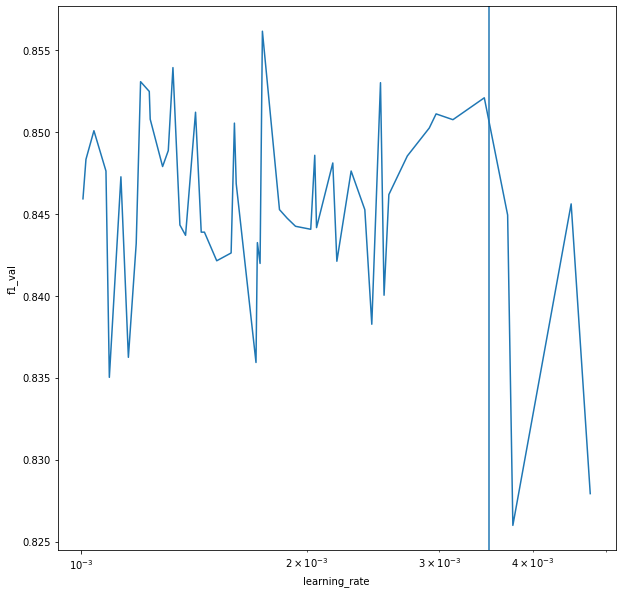

In [42]:
plt.figure(figsize=(10,10))
sns.lineplot(x='learning_rate',y='f1_val',data = results)
plt.xscale('log')
plt.axvline(3.5e-3)
plt.show()

In [49]:
np.round(np.log10(3.5e-3),4)

-2.4559

In [ ]:
3.5

In [63]:
10**-2.5

0.0031622776601683794